In [1]:
import numpy as np # primary math library
import matplotlib.pyplot as plt # primary plotting library
%matplotlib inline

import nelpy as nel # should be installed using pip install nelpy

import warnings
#warnings.filterwarnings("ignore") # useful to prevent excess nelpy warnings

In [6]:
dataroot = '/Users/ckemere/Development/Data/Frank/';

In [7]:
import os

filename = os.path.join(dataroot,'FrankLabData.nel')
import pandas as pd
import nelpy.io
jar = nel.load_pkl(filename)


In [8]:
data = jar.data
tetinfo = jar.tetinfo
cellinfo = jar.cellinfo
taskinfo = jar.taskinfo

In [9]:
from numpy import unravel_index

anim = 'Bon'
novel_epochs = [1,3]
familiar_epochs = 5
epochs = novel_epochs

sigma_500ms = 0.5
# Bin sizes are 500 ms, and then we sli 
ds_run = 0.250 # 250 ms
ds_50ms = 0.05


sigma_250ms = 0.25 # 250 ms spike smoothing

# Bins for tuning curves
x_extents = [10,160] # Read these off of maze figure above
nx = np.diff(x_extents)/5 # plan for 5 cm bins

y_extents = [20,190]
ny = np.diff(y_extents)/5

min_duration = 1 # require that estimation periods be at least 1 second long

# Smoothing standard deviation
sigma_tc = 5 # tuning curve smoothing std in cm


min_spikes = 5

PFCenters = {}
TuningCurves = {}

for day, daydata in data[anim].items():
    # The animal "Bon" had good data on day 3
    S = daydata['spikes']
    pos = daydata['pos']

    speed = nel.utils.dxdt_AnalogSignalArray(pos[epochs,:], smooth=True, sigma=sigma_500ms)

    # get_run_epochs is a utility function which wraps a speed threshold. This finds periods where the speed
    #   is greater than v2 and reaches at least a maximum of v1.
    run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice
    run_epochs = pos[epochs,:].support.intersect(run_epochs)    
    
    st_run = S[run_epochs]
    
    # bin, smooth and re-bin:
    bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma_250ms, inplace=True).rebin(w=ds_run/ds_50ms)

    tc = nel.TuningCurve2D(bst=bst_run, extern=pos, 
                           ext_xmin=x_extents[0], ext_xmax=x_extents[1], 
                           ext_ymin=y_extents[0], ext_ymax=y_extents[1],
                           ext_nx=nx, ext_ny=ny,
                           sigma=sigma_tc, min_duration=1)

    TuningCurves[day] = tc
    PFCenters[day] = []

    for idx, pf in enumerate(tc.ratemap):
        placefield = pf.T
        peak = unravel_index(placefield.squeeze().argmax(),placefield.shape)
        PFCenters[day].append([idx, placefield.max(), peak[0], peak[1]])
        
    


            

/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_spiketrain.py:360: UserWarning: unit tags have not yet been specified
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_spiketrain.py:360: UserWarning: unit tags have not yet been specified
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


In [10]:
filename = os.path.join(dataroot,'FrankLabCenterArm.nel')
jar = nel.load_pkl(filename)
NovelCenterBounds = jar.NovelCenterBounds['Bon']
FamiliarCenterBounds = jar.FamiliarCenterBounds['Bon']

/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of 

NameError: name 'CenterBounds' is not defined

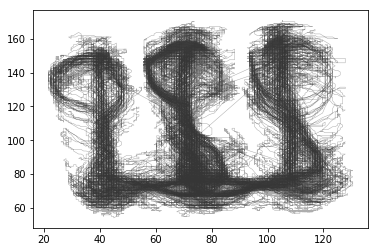

In [11]:
fig, ax = plt.subplots()

PF_data = {}

for day, daydata in data[anim].items():
    # The animal "Bon" had good data on day 3
    S = daydata['spikes']
    pos = daydata['pos']
    # Find placefield centers
    tvals, vals = pos[epochs,:].asarray() # Access timestamps and channel data as numpy arrays
    xvals, yvals = vals # Access two channels as x and y
    ax.plot(xvals, yvals, lw=0.5, c='0.2', alpha=0.4)

for day, daydata in data[anim].items():
    S = daydata['spikes']

    maxrate = np.array(PFCenters[day])
    maxrate = maxrate[:,1]
    p = np.array(PFCenters[day],dtype=int)
    pfcenters = np.vstack((tc.xbin_centers[p[:,3]], tc.ybin_centers[p[:,2]])).T

    # Find left and right arm PFs
    left = (np.cross(pfcenters-CenterBounds[0],CenterBounds[5]-CenterBounds[0]) < 0)
    right = (np.cross(pfcenters-CenterBounds[2],CenterBounds[3]-CenterBounds[2]) > 0)
    center = np.logical_and(np.logical_not(left), np.logical_not(right))
    
    left = np.logical_and(left, maxrate > 2)
    right = np.logical_and(right, maxrate > 2)
    center = np.logical_and(center, maxrate > 2)
    inactive = maxrate <= 2

    ax.plot(pfcenters[left,0], pfcenters[left,1],'o',c='lightgreen')
    ax.plot(pfcenters[right,0], pfcenters[right,1],'o',c='lightgreen')
    ax.plot(pfcenters[center,0], pfcenters[center,1],'o',c='dodgerblue')
    
    PF_data[day] = np.column_stack((np.array(PFCenters[day]), np.array(inactive), 
                              np.array(center), np.array(left), np.array(right)));
    
    print(PF_data[day].shape,S.n_units)



In [175]:
RipThresh = 5 # x sigma over mean
minThresholdLength = 0.015
minLength = 0.025
maxLength = 2

all_swr_events = {}
for day, daydata in data[anim].items():
    # The animal "Bon" had good data on day 3
    S = daydata['spikes']
    pos = daydata['pos']

    tetrode = tetinfo.query('Animal==@anim & maxcell==1 & area=="CA1" & Day==@day').Tetrode.tolist()[0]
    import os.path
    filename = os.path.join('LFP','LFP_{}_{:02d}_{:02d}.nel'.format('Bon',day,tetrode))
    print('Loading: {}'.format(filename))
    if os.path.exists(filename):
        lfpjar = nel.load_pkl(filename)
    else:
        print('No LFP file for {}'.format(filename))
        continue

    lfpdata = lfpjar.lfpdata
    rippledata = nel.filtering.ripple_band_filter(lfpdata)
    ripple_env = nel.utils.signal_envelope1D(rippledata)
    
    m = ripple_env.ydata.mean()
    s = ripple_env.ydata.std()
    PrimaryThreshold = m + RipThresh*s
    SecondaryThreshold = m
    fs = ripple_env.fs
    
    swr_bounds_idx, maxes, _ = nel.utils.get_events_boundaries(
        x = ripple_env.ydata,
        PrimaryThreshold = PrimaryThreshold,
        SecondaryThreshold = SecondaryThreshold,
        minThresholdLength = minThresholdLength,
        minLength = minLength,
        maxLength = maxLength,
        ds = 1/fs
    )
    
    # store MUA bounds in an EpochArray
    swr_epochs = nel.EpochArray(ripple_env.time[swr_bounds_idx])
    all_swr_events[day] = swr_epochs

Loading: LFP/LFP_Bon_02_28.nel
No LFP file for LFP/LFP_Bon_02_28.nel
Loading: LFP/LFP_Bon_03_13.nel
Loading: LFP/LFP_Bon_04_13.nel
Loading: LFP/LFP_Bon_05_11.nel
Loading: LFP/LFP_Bon_06_13.nel
Loading: LFP/LFP_Bon_07_04.nel
Loading: LFP/LFP_Bon_08_11.nel
Loading: LFP/LFP_Bon_09_13.nel


In [176]:
import nelpy.io
#np.savez_compressed('FrankLabPickle.npz', data=data, cellinfo=cellinfo, taskinfo=taskinfo)
BonSWREvents = nel.ResultsContainer(swr_epochs=all_swr_events,
                                    description='Data from the lab of Loren Frank CRCNS archive.\n')
BonSWREvents.save_pkl('BonSWREvents.nel')

(1364,)


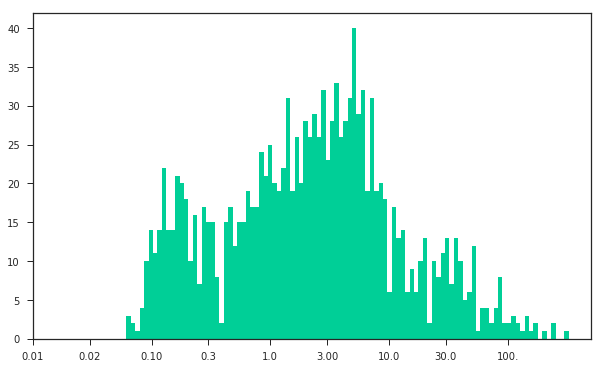

In [188]:
import nelpy.plotting as npl
# Set default figure aesthetics
npl.setup(font_scale=1)

post_sleep_epochs = [ep+1 for ep in epochs]
inter_swr_intervals = []
for day, swr_eps in all_swr_events.items():
    for ep in post_sleep_epochs:
        post_sleep_swr = swr_eps.intersect(pos.support[ep])
        swrtimes = post_sleep_swr.centers
        inter_swr_intervals.append(np.diff(swrtimes))

inter_swr_intervals = np.hstack(inter_swr_intervals)
print(inter_swr_intervals.shape)
with npl.FigureManager(show=True, figsize=(10, 6)) as (fig, ax):    
    ax.hist(np.log(inter_swr_intervals),bins=100);
    ax.set_xticks(np.log([0.01,0.03,0.1,0.3,1,3,10,30,100]))
    ax.set_xticklabels(np.exp(ax.get_xticks()).astype('|U4'))

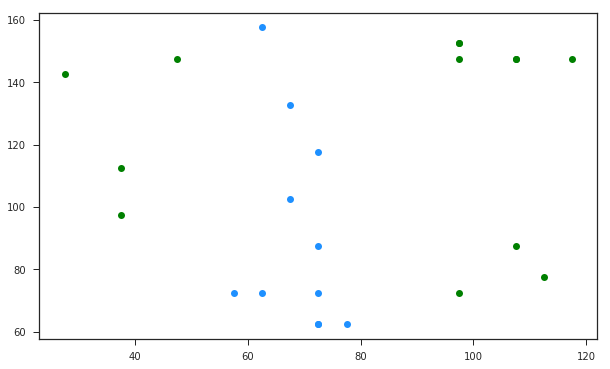

In [158]:
with npl.FigureManager(show=True, figsize=(10, 6)) as (fig, ax):    
    maxrate = np.array(PFCenters[day])
    maxrate = maxrate[:,1]
    p = np.array(PFCenters[day],dtype=int)
    pfcenters = np.vstack((tc.xbin_centers[p[:,3]], tc.ybin_centers[p[:,2]])).T

    # Find left and right arm PFs
    left = (np.cross(pfcenters-CenterBounds[0],CenterBounds[5]-CenterBounds[0]) < 0)
    right = (np.cross(pfcenters-CenterBounds[2],CenterBounds[3]-CenterBounds[2]) > 0)
    center = np.logical_and(np.logical_not(left), np.logical_not(right))
    
    left = np.logical_and(left, maxrate > 2)
    right = np.logical_and(right, maxrate > 2)
    center = np.logical_and(center, maxrate > 2)
    inactive = maxrate <= 2

    ax.plot(pfcenters[left,0], pfcenters[left,1],'o',c='green')
    ax.plot(pfcenters[right,0], pfcenters[right,1],'o',c='green')
    ax.plot(pfcenters[center,0], pfcenters[center,1],'o',c='dodgerblue')


In [218]:
import pandas as pd

swr_table = []

for day, swr_eps in all_swr_events.items():
    for ep in post_sleep_epochs:
        S = data[anim][day]['spikes']
        
        print(day,S.n_units, PF_data[day].shape)

        post_sleep_swr = swr_eps.intersect(pos.support[ep])
        post_sleep_spikes = S[post_sleep_swr]
        swrtimes = post_sleep_swr.centers
        isi = np.insert(np.diff(swrtimes),0,-np.nan)
        for idx, swr in enumerate(post_sleep_spikes):
            swr_table.append([
                swrtimes[idx],
                isi[idx],
                swr[:,np.argwhere(PF_data[day][:,4])].n_active,
                swr[:,np.argwhere(PF_data[day][:,5])].n_active,
                swr[:,np.argwhere(PF_data[day][:,6])].n_active,
                swr[:,np.argwhere(PF_data[day][:,7])].n_active,
            ])

swr_df = pd.DataFrame(swr_table,columns=['time','isi','inactive','center','left','right'])

3 74 (74, 8)
3 74 (74, 8)
4 60 (60, 8)
4 60 (60, 8)
5 67 (67, 8)
5 67 (67, 8)
6 62 (62, 8)
6 62 (62, 8)
7 49 (49, 8)
7 49 (49, 8)
8 64 (64, 8)
8 64 (64, 8)
9 61 (61, 8)
9 61 (61, 8)


In [224]:
swr_df.astype(bool).sum()

time        1180
isi         1180
inactive     321
center       816
left         406
right        382
dtype: int64

In [274]:
left_isi = []
right_isi = []
center_isi = []
inactive_isi = []

last_left = np.nan
last_right = np.nan
last_center = np.nan
last_inactive = np.nan

for idx, row in swr_df.iterrows():
    if np.isnan(row['isi']):
        last_left = np.nan
        last_right = np.nan
        last_center = np.nan
        last_inactive = np.nan

    if row['left'] > 0:
        if ~np.isnan(last_left):
            left_isi.append( (row['time'] - last_left)/row['isi'] )
        last_left = row['time']
        
    if row['right'] > 0:
        if ~np.isnan(last_right):
            right_isi.append( (row['time'] - last_right)/row['isi'] )
        last_right = row['time']
        
    if row['center'] > 0:
        if ~np.isnan(last_center):
            center_isi.append(row['time'] - last_center)
        last_center = row['time']
        
    if row['inactive'] > 0:
        if ~np.isnan(last_inactive):
            inactive_isi.append(row['time'] - last_inactive)
        last_inactive = row['time']


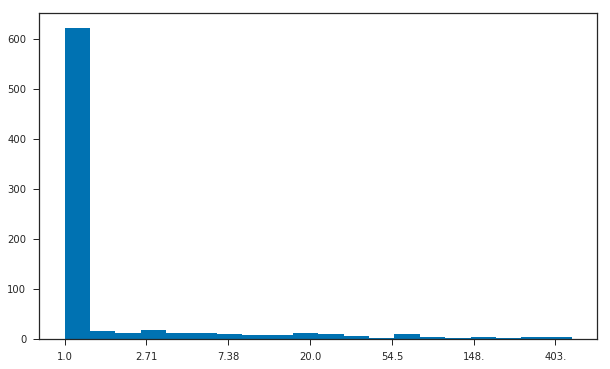

In [304]:
import seaborn as sns
sns.set_palette('colorblind')
with npl.FigureManager(show=True, figsize=(10, 6)) as (fig, ax):
    #sns.distplot(np.log(inter_swr_intervals),hist=True,norm_hist=True,bins=50,label='SWR');
    #sns.distplot(np.log(inactive_isi),hist=True,norm_hist=True,bins=25,label='Inactive');
    #sns.distplot(np.log(center_isi),hist=True,norm_hist=True,bins=50,label='Center');
    #sns.distplot(np.log(left_isi),hist=True,norm_hist=True,bins=25,label='Left');
    #sns.distplot(np.log(right_isi),hist=True,norm_hist=True,bins=25,label='Right');
    ax.hist(np.log(right_isi+left_isi),bins=20,label='Same Arm');
    #ax.set_xticks(np.log([1,3,10,30,100,300,1000]))
    ax.set_xticklabels(np.exp(ax.get_xticks()).astype('|U4'))


In [291]:
right_isi[1:4]

[2.9670631067961115, 22.390794899297358, 1.8659202621517603]

In [293]:
np.sum(swr_df.left.astype(bool) & swr_df.right.astype(bool))

61